# Stock Portfolio Optimisation Tool Using Artificial Intelligence
## Thomas Lowe

In [2]:
%load_ext watermark
%load_ext tensorboard

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
#loads required packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import ipywidgets as w
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import csv

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Anaconda\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [30]:
def display_widget():
    print ("\nPlease enter the dates you wish to retrieve stock data from")
    #Declare the widgets as global variables so they can be used in the next function
    global start_date_widget, end_date_widget
    start_date_widget = w.DatePicker(description='Start Date')
    end_date_widget = w.DatePicker(description='End Date')
    #Displays the widget datepicker that was just created
    display(start_date_widget, end_date_widget)
    
def date_from_widget():
    #converts the dates into strings
    start_date = str(start_date_widget.value)
    end_date = str(end_date_widget.value)
    return start_date, end_date

# Markowitz

In [6]:
#companylist.csv is made from a list of nasdaq listed companies as of 09/04/2020
#ftp://ftp.nasdaqtrader.com/symboldirectory
companylist = []
with open('companylist.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        companylist.append(row[0])

In [31]:
tickers = []
conditional = input("Would you like to use the placeholder tickers? Type 'n' to use your own.\n Any other entry will use placeholders.").lower()

if conditional == ("n"):
    counter = 0
    while counter != 1:
        firstTicker = input("\nPlease enter the first ticker here. I.e. AAPL.").upper()
        if firstTicker in companylist:
            tickers.append(firstTicker)
            counter = counter+1
        else:
            print (firstTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 2:
        secondTicker = input("Please enter the second ticker here. I.e. FB.").upper()
        if secondTicker in companylist:
            tickers.append(secondTicker)
            counter = counter+1
        else:
            print (secondTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 3:
        thirdTicker = input("Please enter the third ticker here. I.e. TSLA.").upper()
        if thirdTicker in companylist:
            tickers.append(thirdTicker)
            counter = counter+1
        else:
            print (thirdTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 4:
        fourthTicker = input("Please enter the fourth ticker here. I.e. MSFT.").upper()
        if fourthTicker in companylist:
            tickers.append(fourthTicker)
            counter = counter+1
        else:
            print (fourthTicker+" is not a valid ticker. Please enter a valid ticker.")
    print ("You have entered the following "+str(tickers))
else:
    #Declares the stock tickers that are to be used
    #Tickers are a stocks unique identifier
    tickers = ['FB','AAPL','TSLA','BP']
    
#Uses the tickers to get information from YahooFinancials package
yahoo_financials = yf(tickers)
display_widget()

Would you like to use the placeholder tickers? Type 'n' to use your own.
 Any other entry will use placeholders.y

Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [32]:
date_from_widget()
#Pulls the start_date, end_date variables from the date_from_widget function
start_date,end_date = date_from_widget()
print(start_date,end_date)

2017-01-01 2020-01-01


In [33]:
data = yahoo_financials.get_historical_price_data(start_date,end_date,'daily')

prices_df = pd.DataFrame({
        asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in tickers
})

prices_df.index.name="Formatted_Date"
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.head()

,FB,AAPL,TSLA,BP
Formatted_Date,,,,
2017-01-03,116.860001,110.691154,216.990005,31.103085
2017-01-04,118.690002,110.567276,226.990005,31.340450
2017-01-05,120.669998,111.129562,226.750000,31.569630
2017-01-06,123.410004,112.368469,229.009995,31.029415
2017-01-09,124.900002,113.397697,231.279999,30.538322


Text(0.5, 0, 'Date')

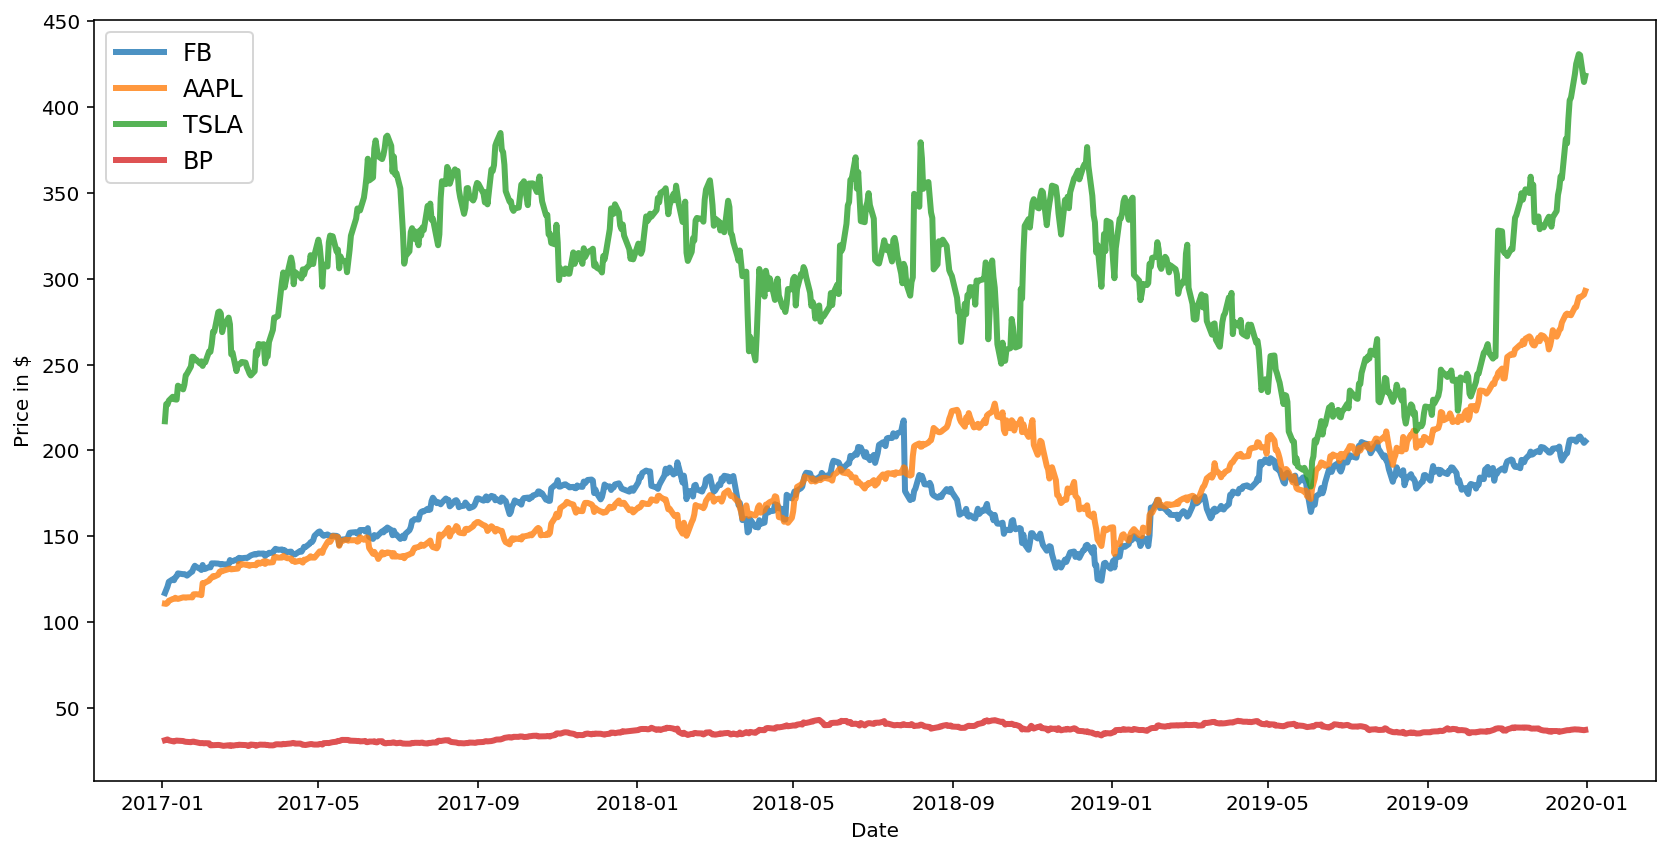

In [34]:
plt.figure(figsize=(14,7))
for c in prices_df.columns.values:
    plt.plot(prices_df.index,prices_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

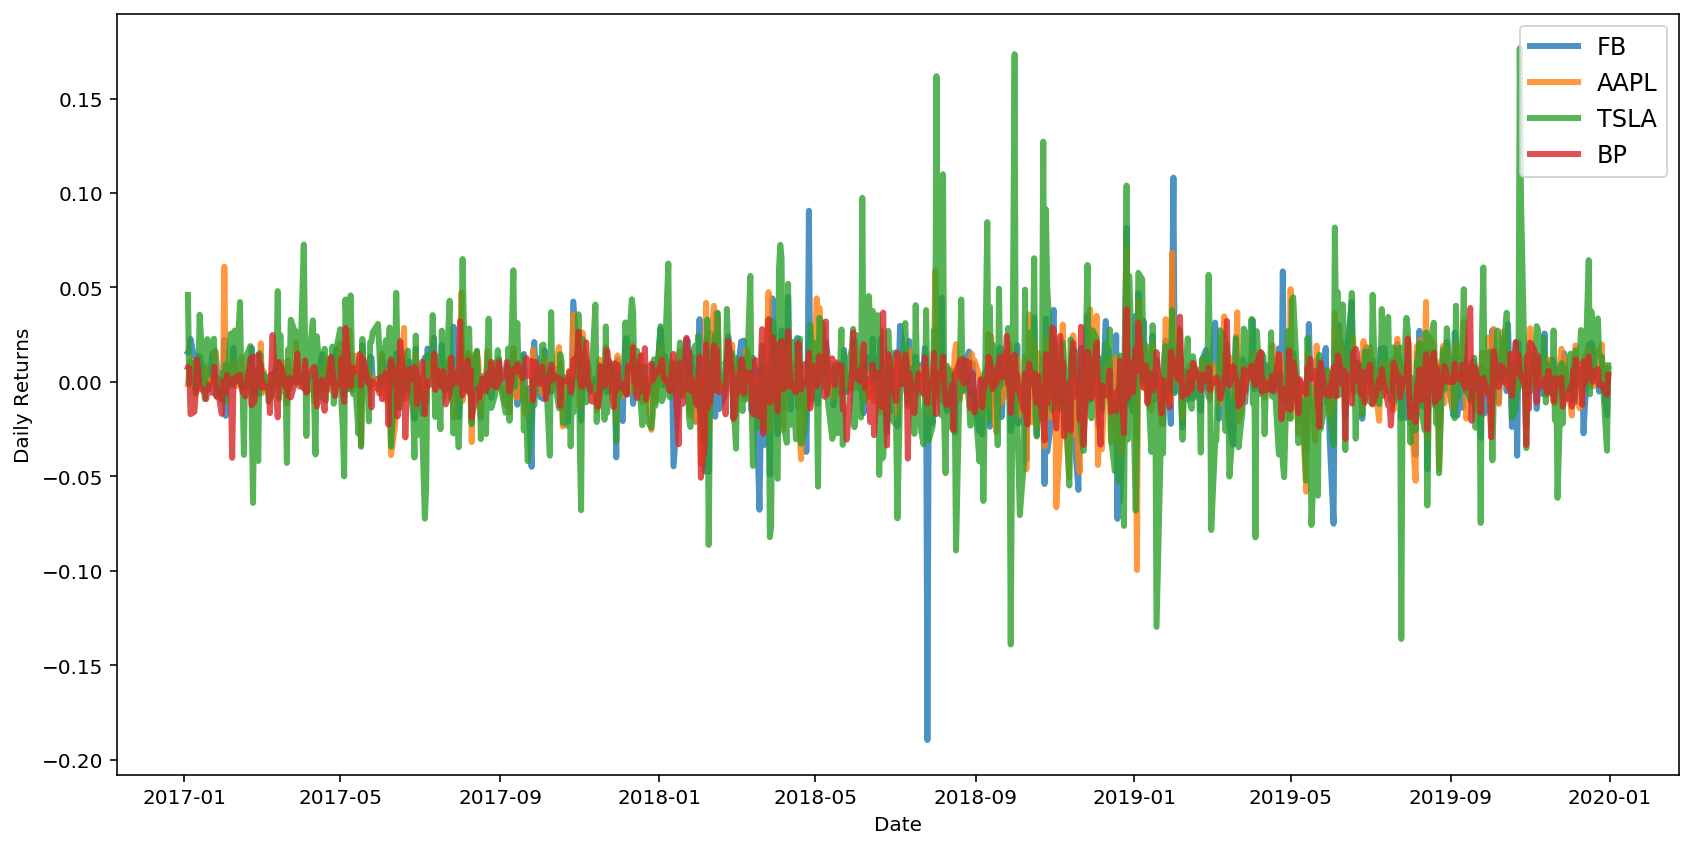

In [35]:
returns = prices_df.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right',fontsize=12)
plt.ylabel('Daily Returns')
plt.xlabel('Date')

In [36]:
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    #252 represents the number of trading days in a year
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [15]:
returns = prices_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [16]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=prices_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]

    max_sharpe_allocation.allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print (prices_df)

    

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.19


               FB   AAPL   TSLA     BP
allocation  40.59  28.05  18.15  13.21
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.15


               FB  AAPL   TSLA     BP
allocation  64.41  3.57  14.43  17.59
                       FB       AAPL       TSLA         BP
Formatted_Date                                            
2012-05-18      38.230000  65.770210  27.559999  23.393652
2012-05-21      34.029999  69.601997  28.770000  23.778296
2012-05-22      31.000000  69.067520  30.799999  23.866570
2012-05-23      32.000000  70.752777  31.020000  23.910711
2012-05-24      33.029999  70.102989  30.280001  24.106182
...                   ...        ...        ...        ...
2012-05-11          

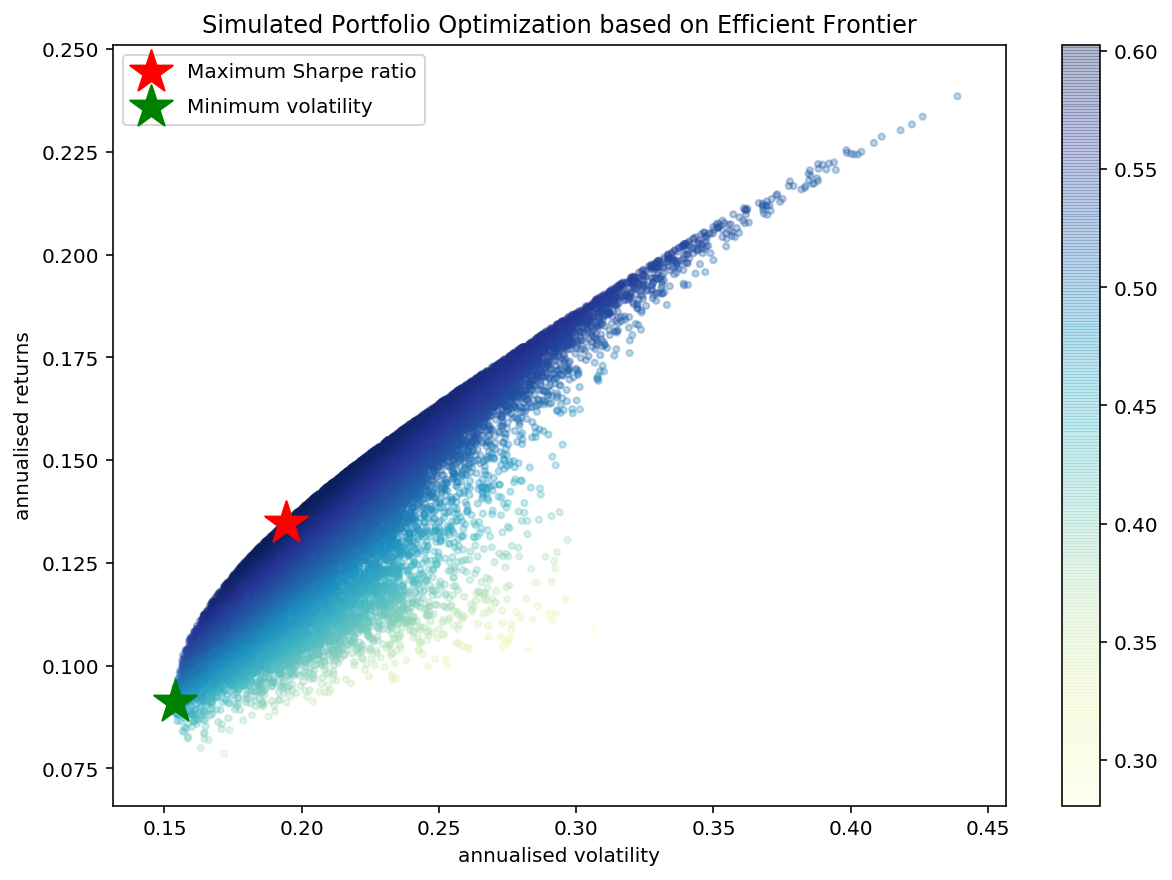

In [17]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Algorithm

In [75]:
display_widget()


Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [95]:
date_from_widget()
start_date,end_date = date_from_widget()
print(start_date,end_date)

2015-01-01 2020-01-01


In [96]:
while True:
    ticker = input("Please enter a ticker here. I.e. BP.").upper()
    if ticker in companylist:
        yahoo_finacials = yf(ticker)
        break
    else:
        print ("\n'"+ticker+"' is not a valid ticker, please try again.")
data = yahoo_finacials.get_historical_price_data(start_date, end_date, "daily")
print ("\nThe ticker you have selected is '"+ticker+"'.")

Please enter a ticker here. I.e. BP.AAPL

The ticker you have selected is 'AAPL'.


In [97]:
userInput_df = pdr.get_data_yahoo(ticker,
                          start_date,
                          end_date
                          )
userInput_df.head()
userInput_df=userInput_df.Close
userInput_df.head()

Date
2015-01-02    109.330002
2015-01-05    106.250000
2015-01-06    106.260002
2015-01-07    107.750000
2015-01-08    111.889999
Name: Close, dtype: float64

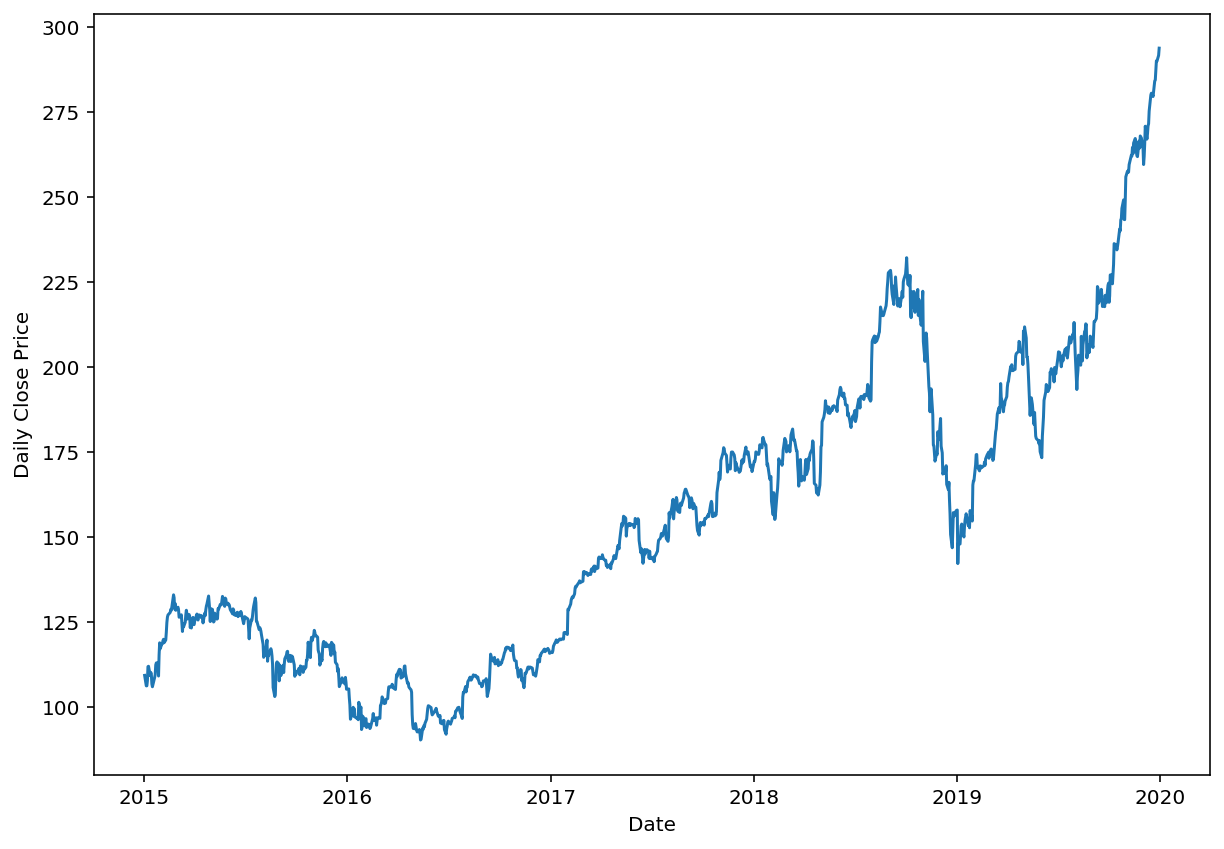

In [98]:
plt.figure(figsize=(10, 7))
plt.plot(userInput_df)
plt.ylabel('Daily Close Price')
plt.xlabel('Date')
plt.show()

In [99]:
X = userInput_df.values
train_size = int(len(X)*0.66)
train, test = X[1:train_size], X[train_size:]

RMSE: 3.404


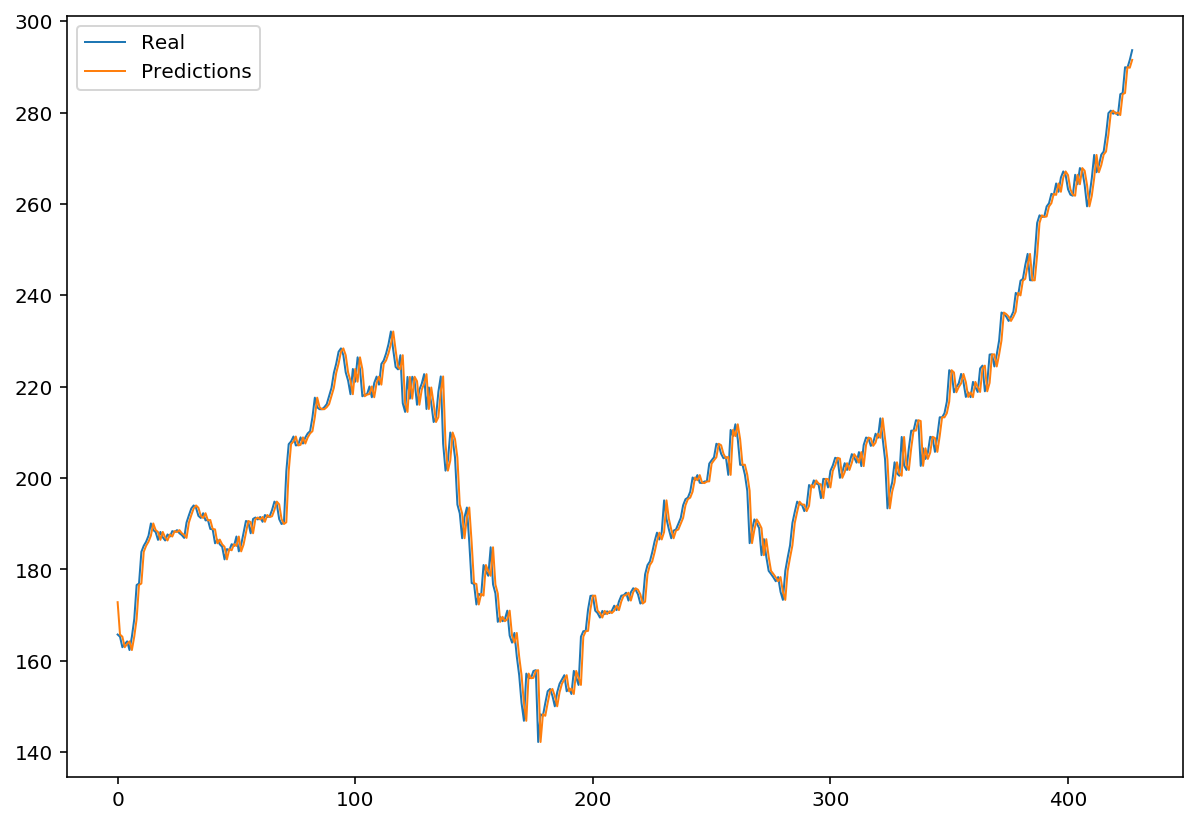

In [100]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])
#This is the percentage that the predictions deviate from the actual values
#Close rmse is to 0, the more accurate the model is
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(10, 7))
plt.plot(test, label='Real', linewidth=1)
plt.plot(predictions, label='Predictions', linewidth=1)
plt.legend(['Real','Predictions'])
plt.show()

In [101]:
knn_df = pdr.get_data_yahoo(ticker,
                    start=start_date,
                    end=end_date)
knn_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.829773
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.954712


In [102]:
knn_df['Open-Close'] = (knn_df['Close'].shift(1))-knn_df['Open']
knn_df['High-Low'] = knn_df['High']-knn_df['Low']
knn_df = knn_df.dropna()
X = knn_df[['Open-Close','High-Low']]
X.tail()

,Open-Close,High-Low
Date,,
2019-12-24,-0.690002,1.970001
2019-12-26,-0.550018,5.279999
2019-12-27,-1.209991,5.850006
2019-12-30,0.339996,7.470001
2019-12-31,1.589996,4.160004


In [103]:
Y = np.where(knn_df['Open'].shift(-1)>knn_df['Open'],1,-1)

In [104]:
split_percentage = 0.7
split = int(split_percentage*len(knn_df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

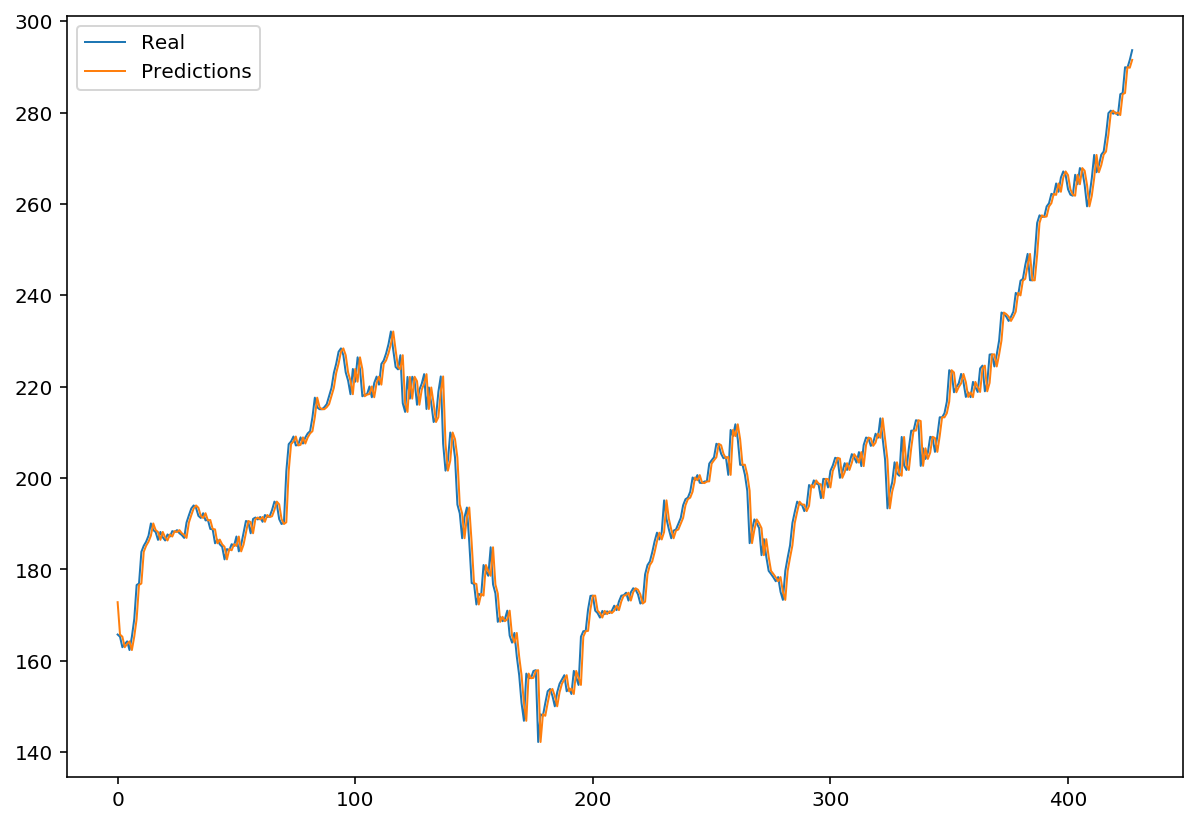

Train_data Accuracy: 0.61
Test_data Accuracy: 0.52


In [105]:
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, Y_train)

accuracy_train = accuracy_score(Y_train,knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

plt.figure(figsize=(10, 7))
plt.plot(test, label='Real', linewidth=1)
plt.plot(predictions, label='Predictions', linewidth=1)
plt.legend(['Real','Predictions'])
plt.show()

print('Train_data Accuracy: %.2f' %accuracy_train)
print('Test_data Accuracy: %.2f' %accuracy_test)

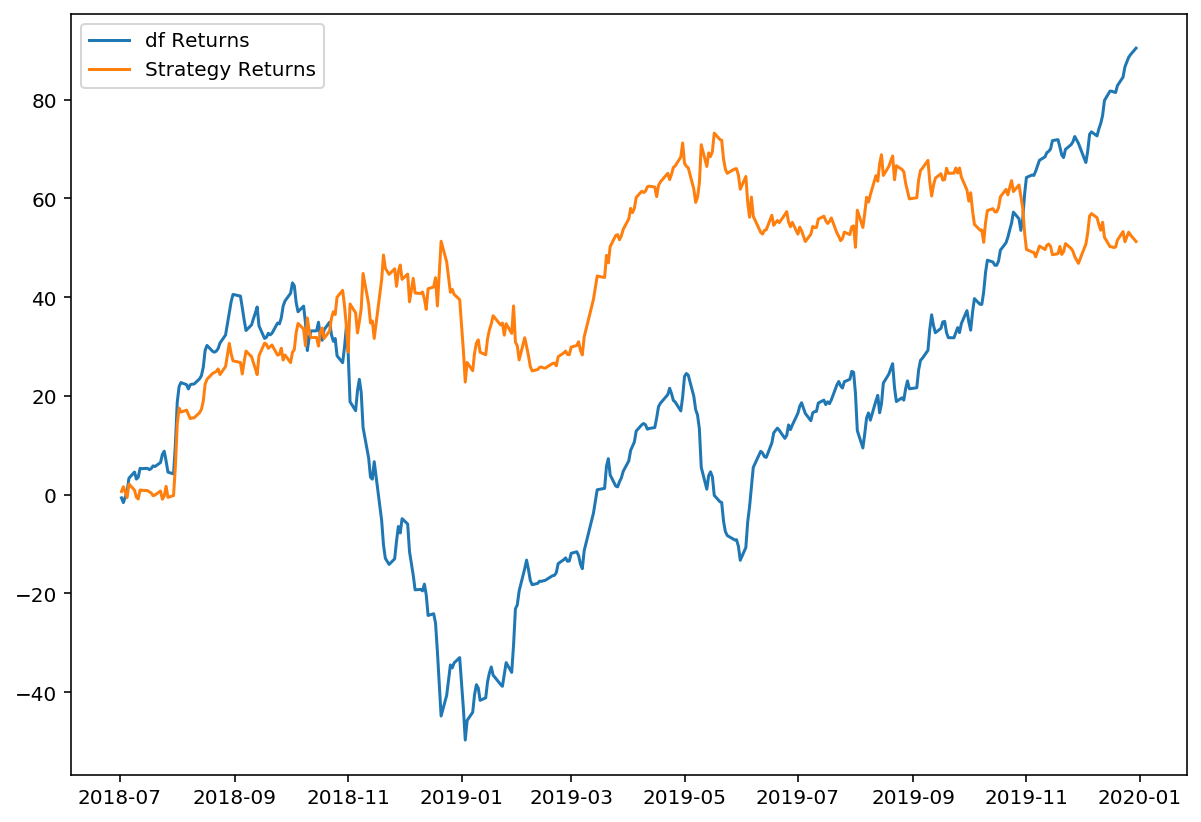

In [106]:
knn_df['Predicted_Signal'] = knn.predict(X)

knn_df['Df_returns'] = np.log((knn_df['Close'].shift(-1))/knn_df['Close'].shift(1))
Cumulative_df_Returns = knn_df[split:]['Df_returns'].cumsum()*100

knn_df['Strategy_Returns'] = knn_df['Df_returns']*knn_df['Predicted_Signal'].shift(1)
Cum_Strategy_Returns = knn_df[split:]['Strategy_Returns'].cumsum()*100

plt.figure(figsize=(10,7))
plt.plot(Cumulative_df_Returns, label='df Returns')
plt.plot(Cum_Strategy_Returns, label='Strategy Returns')
plt.legend()
plt.show()


In [109]:
Cum_Strategy_Returns = Cum_Strategy_Returns.dropna()
Cumulative_df_Returns = Cumulative_df_Returns.dropna()
print(Cum_Strategy_Returns.tail(1))
print(Cumulative_df_Returns.tail(1))

Date
2019-12-30    51.286033
Name: Strategy_Returns, dtype: float64
Date
2019-12-30    90.447621
Name: Df_returns, dtype: float64


In [110]:
Std = Cum_Strategy_Returns.std()
Sharpe = (Cum_Strategy_Returns-Cumulative_df_Returns)/Std
Sharpe = Sharpe.mean()
print ('Sharpe ratio: %.2f'%Sharpe)

Sharpe ratio: 1.47
